In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report

import string
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv(r"C:\Users\afrin\Documents\Amazon Fine Food Reviews\data\processed\Reviews.csv")

In [5]:
#80:20
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1, stratify = y)

In [6]:
X_train.shape, X_test.shape

((291107,), (72777,))

In [7]:
#TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [8]:
#Label Encodding
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Positive']


In [9]:
#Logistic Regression with TF IDF
log_model = LogisticRegression(C=1e5).fit(tfidf_X_train, y_train)
y_pred_log = log_model.predict(tfidf_X_test)

In [10]:
#Multinomial Naive Bayes with TFIDF
multinomial_model = MultinomialNB().fit(tfidf_X_train, y_train)
y_pred_multinomial = multinomial_model.predict(tfidf_X_test)

In [11]:
#Bernoulli Naive Bayes with TFIDF
bernoulli_model = BernoulliNB().fit(tfidf_X_train, y_train)
y_pred_bernoulli = bernoulli_model.predict(tfidf_X_test)

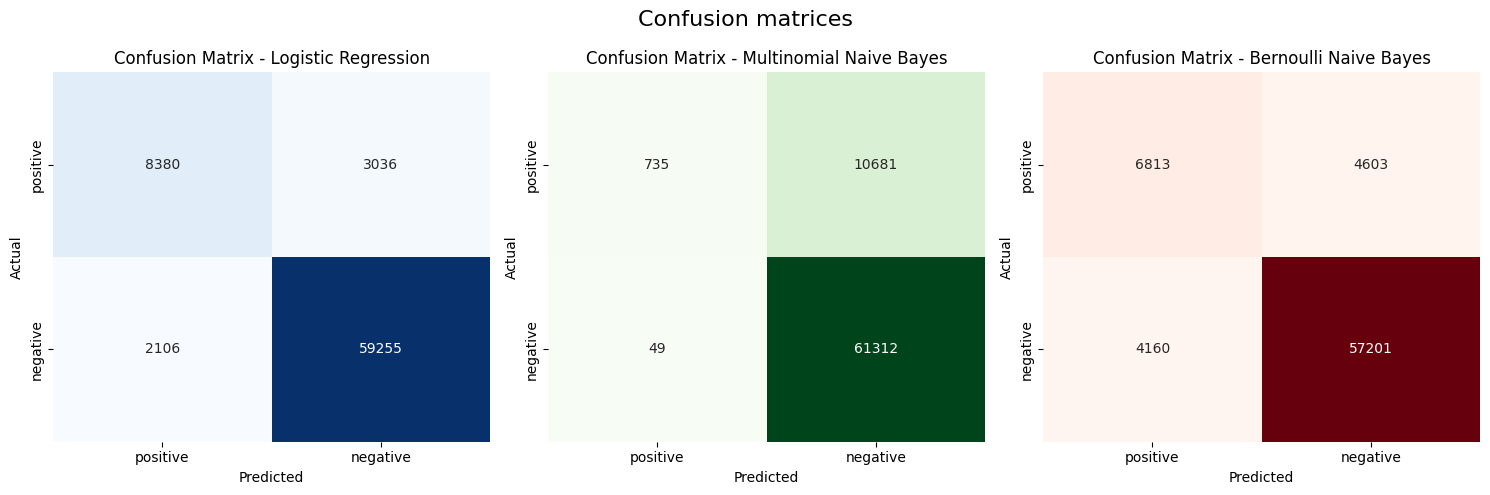

In [12]:
#Confussion Matrices
# Confusion matrix for Logistic Regression
conf_matrix_log = confusion_matrix(y_test, y_pred_log)

# Confusion matrix for Multinomial Naive Bayes
conf_matrix_nb = confusion_matrix(y_test, y_pred_multinomial)

# Confusion matrix for Bernoulli Naive Bayes
conf_matrix_bernoulli = confusion_matrix(y_test, y_pred_bernoulli)

# Plotting confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)

sns.heatmap(conf_matrix_log, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
ax1.set_title('Confusion Matrix - Logistic Regression')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(["positive", "negative"])
ax1.set_yticklabels(["positive", "negative"])

sns.heatmap(conf_matrix_nb, annot=True, cmap='Greens', fmt='d', cbar=False, ax=ax2)
ax2.set_title('Confusion Matrix - Multinomial Naive Bayes')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(["positive", "negative"])
ax2.set_yticklabels(["positive", "negative"])

sns.heatmap(conf_matrix_bernoulli, annot=True, cmap='Reds', fmt='d', cbar=False, ax=ax3)
ax3.set_title('Confusion Matrix - Bernoulli Naive Bayes')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_xticklabels(["positive", "negative"])
ax3.set_yticklabels(["positive", "negative"])

fig.suptitle("Confusion matrices", fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
#Classification Report
print('Classification Report:')

# Logistic Regression
print('Logistic Regression')
print(classification_report(y_test, y_pred_log))

# Multinomial Naive Bayes
print('\nMultinomial Naive Bayes')
print(classification_report(y_test, y_pred_multinomial))

# Bernoulli Naive Bayes
print('\nBernoulli Naive Bayes')
print(classification_report(y_test, y_pred_bernoulli))

Classification Report:
Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.73      0.77     11416
           1       0.95      0.97      0.96     61361

    accuracy                           0.93     72777
   macro avg       0.88      0.85      0.86     72777
weighted avg       0.93      0.93      0.93     72777


Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.94      0.06      0.12     11416
           1       0.85      1.00      0.92     61361

    accuracy                           0.85     72777
   macro avg       0.89      0.53      0.52     72777
weighted avg       0.87      0.85      0.79     72777


Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0       0.62      0.60      0.61     11416
           1       0.93      0.93      0.93     61361

    accuracy                           0.88     72777
   macro avg       0.77      0.76    

In [14]:
#Model accuracy
accuracy = {}

# Calculate accuracy for each model
accuracy['Logistic Regression'] = accuracy_score(y_test, y_pred_log)
accuracy['Multinomial Naive Bayes'] = accuracy_score(y_test, y_pred_multinomial)
accuracy['Bernoulli Naive Bayes'] = accuracy_score(y_test, y_pred_bernoulli)

# Create a datafame to display the accuracies
accuracy_table = pd.DataFrame(list(accuracy.items()), columns=['Model', 'Accuracy'])
accuracy_table

,Model,Accuracy
0,Logistic Regression,0.929346
1,Multinomial Naive Bayes,0.852563
2,Bernoulli Naive Bayes,0.879591


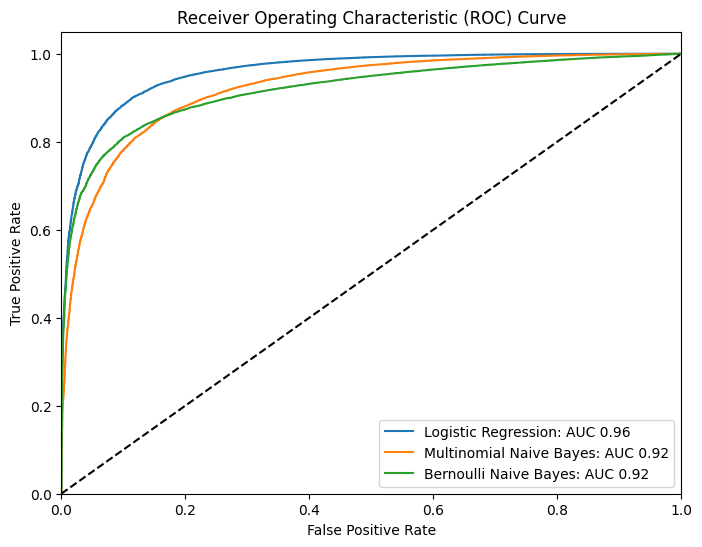

In [15]:
#ROC - AUC Curve
# Predictions for classifiers stored in 'predictions' dictionary
predictions = {
    'Logistic Regression': log_model.predict_proba(tfidf_X_test)[:, 1],
    'Multinomial Naive Bayes': multinomial_model.predict_proba(tfidf_X_test)[:, 1],
    'Bernoulli Naive Bayes': bernoulli_model.predict_proba(tfidf_X_test)[:, 1]}

# Plotting ROC curves for each classifier
plt.figure(figsize=(8, 6))

for model, predicted_probs in predictions.items():
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predicted_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(
        false_positive_rate, 
        true_positive_rate, 
        label='%s: AUC %0.2f' % (model, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()